# Applying Regression on Stock Prices  
In this notebook we will be applying a number of regression algorithms present in the Scikit Learn library. 


In [24]:
%config IPCompleter.greedy=True

In [61]:
# Lets import a few important libraries first
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling 


In [4]:
# yFinance will help us fetch the data for our dataset
import yfinance as yf

## Fetch Data from Yahoo Finance
Time to fetch some data from Yahoo!. We are going to pull 5 years price data of  
FAANG - Facebook Apple Amazon Netflix Google  


In [29]:
# Facebook
data_FB = yf.download("FB", start="2014-01-01", end="2019-09-10")
# Apple
data_AAPL = yf.download("AAPL", start="2014-01-01", end="2019-09-10")
# Amazon
data_AMZN = yf.download("AMZN", start="2014-01-01", end="2019-09-10")
# Netflix
data_NFLX = yf.download("NFLX", start="2014-01-01", end="2019-09-10")
# Google/Alphabet
data_GOOGL = yf.download("GOOGL", start="2014-01-01", end="2019-09-10")

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [38]:
# Validate the Data
# Shape should be same
display(type(data_FB))
display(data_FB.head())
display(data_FB.shape)
display(data_AAPL.shape)
display(data_AMZN.shape)
display(data_NFLX.shape)
display(data_GOOGL.shape)

pandas.core.frame.DataFrame

,Adj Close
Date,
2013-12-31,54.65
2014-01-02,54.71
2014-01-03,54.56
2014-01-06,57.20
2014-01-07,57.92


(1432, 1)

(1432, 1)

(1432, 1)

(1432, 1)

(1432, 1)

## Combine all the Dataframes  
Let's create a single dataframe that contains date and the _Adj Close_ price for each stock.

In [44]:
# Drop all columns except for the Adj Close price 
data_FB = data_FB[['Adj Close']]
data_AAPL = data_AAPL[['Adj Close']]
data_AMZN = data_AMZN[['Adj Close']]
data_NFLX = data_NFLX[['Adj Close']]
data_GOOGL = data_GOOGL[['Adj Close']]

# Merge the Dataframes
stock_data = data_GOOGL.merge(data_AAPL, on='Date', how='left')\
            .merge(data_AMZN, on='Date', how='left')\
            .merge(data_FB, on='Date', how='left')\
            .merge(data_NFLX, on='Date', how='left')
# Fix the column names 
stock_data.columns = ['GOOGL', 'AAPL', 'AMZN', 'FB', 'NFLX']
display(stock_data)

,GOOGL,AAPL,AMZN,FB,NFLX
Date,,,,,
2013-12-31,560.92,72.34,398.79,54.65,52.60
2014-01-02,557.12,71.32,397.97,54.71,51.83
2014-01-03,553.05,69.75,396.44,54.56,51.87
2014-01-06,559.22,70.13,393.63,57.20,51.37
2014-01-07,570.00,69.63,398.03,57.92,48.50
...,...,...,...,...,...
2019-09-03,1169.55,205.70,1789.84,182.39,289.29
2019-09-04,1182.27,209.19,1800.62,187.14,291.52
2019-09-05,1212.19,213.28,1840.72,190.90,293.25


## Calculate Daily Returns 
Instead of directly working with the stock prices, we are going to calculate the _log of Daily Returns_.  
We are going to try and predict the log returns instead of closing prices. 

In [53]:
# Stock Returns 
stock_returns = pd.DataFrame(np.log(stock_data) - np.log(stock_data.shift(1)))
# Drop the first row (need two dates to calculate returns, so NAN returns for the first day)
stock_returns.dropna(axis='index', how='any', inplace=True)
display(stock_returns.shape)
display(stock_returns)

(1431, 5)

,GOOGL,AAPL,AMZN,FB,NFLX
Date,,,,,
2014-01-02,-0.006798,-0.014200,-0.002058,0.001097,-0.014747
2014-01-03,-0.007332,-0.022259,-0.003852,-0.002745,0.000771
2014-01-06,0.011095,0.005433,-0.007113,0.047253,-0.009686
2014-01-07,0.019093,-0.007155,0.011116,0.012509,-0.057491
2014-01-08,0.002086,0.006299,0.009726,0.005338,0.004321
...,...,...,...,...,...
2019-09-03,-0.017780,-0.014671,0.007599,-0.017824,-0.015299
2019-09-04,0.010817,0.016824,0.006005,0.025710,0.007679
2019-09-05,0.024992,0.019363,0.022026,0.019893,0.005917


## EDA on the Stock Returns Data 
Time for some exploratory data analysis on the Stocks returns dataframe.  
Pandas Profiling in Action! 

In [81]:
pandas_profiling.ProfileReport(stock_returns)

### Partial Autocorrelation 
As we can see above, the returns look to be highly correlated.  
Accurately predicting them is going to be hard.
<br/><br/>Let's examine the partial autocorrelation of the return series of each stock. 

In [56]:
# An important import
from statsmodels.graphics.tsaplots import plot_pacf

In [71]:
# Set the size of the plots
plt.rcParams['figure.figsize'] = [12, 6]

In [78]:
def plot_partial_autocorr(series, plot_title, lags):
    """
    Plots the partial autocorrelations plots. 

    Parameters
    ----------
    series : Pandas Series   
        Time series whose partial autocorrelations are to be 
        plotted.
    plot_title : String
        Title of the plot.
    lag : integer
        Lag for the partial autocorrelation plots.  
        
    Returns
    -------
    None. Just plots the plot. 
    """
    
    plot_pacf(series, lags=lags)
    plt.title(plot_title, fontdict={'fontsize':25}, x=0.5, y=0.6)
    plt.show()
    
    return None    

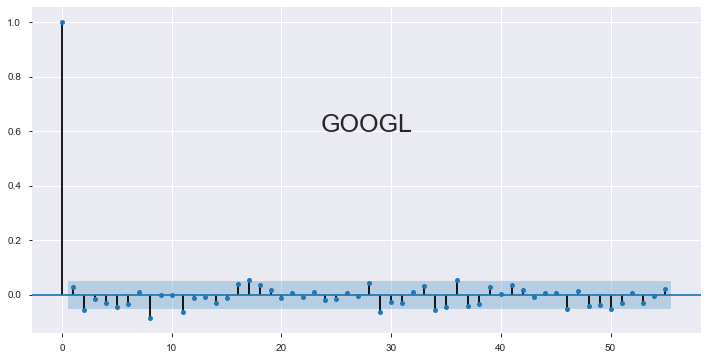

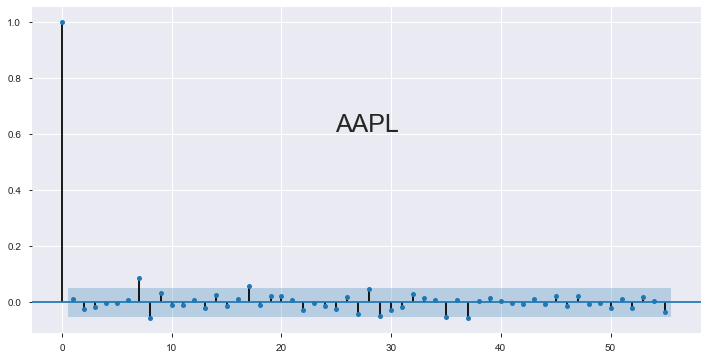

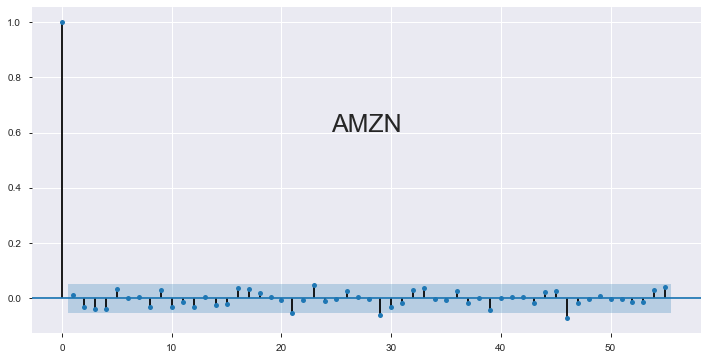

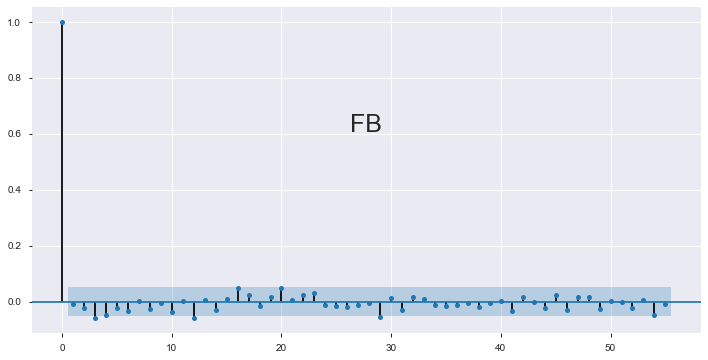

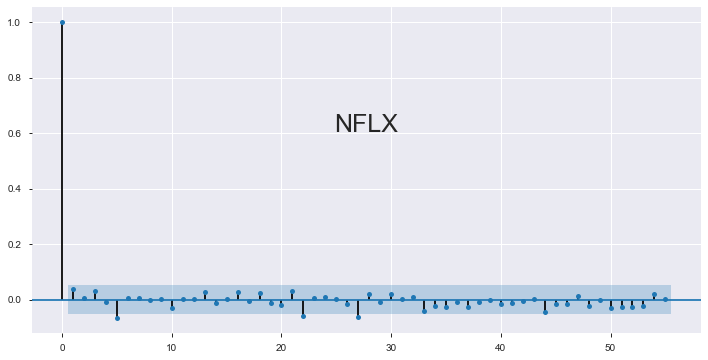

In [80]:
for column in stock_returns.columns:
    plot_partial_autocorr(series=stock_returns[column], plot_title=column, lags=55)

## Predicting Returns using Regression
As we can see from the graphs above, there's pretty much _**NO**_ correlation in the stocks returns time series.  
This implies that historical returns have virtually no predictive effect on the current return.

<br/>With this knowledge in hand, if we try to predict the returns of the above stocks, we should expect a prediction accuracy of around 50%. Since we are practically trying to predict a random variable over here.

<br/>Let's try to predict the stock returns using regression. 

In [82]:
# Import some important things 
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [94]:
# Let's try simple Ridge Regression on Google Returns 
# The regression algorithms in sklearn expect the inputs 
# as 2D arrays, in the form of (n_samples, n_targets). 
# Therefore, we will have to reshape our returns series. 
X_googl = stock_returns['GOOGL'].values.reshape(-1, 1)
# Check
print(X_googl.shape)
display(X_googl[:20])

# The labels Y are going to be nothing but the stock 
# returns for the next day. 
Y_googl = stock_returns['GOOGL'].shift(-1).dropna(how='all').values.reshape(-1,1)
# Check
display(Y_googl)
display(Y_googl.shape)

# Since the Y_googl is 1 short than the X_googl (no future return for the last day!)
# We are going to impute the last row from X_googl
X_googl = np.delete(X_googl, len(X_googl)-1, 0)
# Check 
print(X_googl.shape)

(1431, 1)


array([[-6.79763628e-03],
       [-7.33224323e-03],
       [ 1.10945423e-02],
       [ 1.90934052e-02],
       [ 2.08554304e-03],
       [-9.67567889e-03],
       [-5.30339860e-05],
       [-6.40237709e-03],
       [ 2.32660649e-02],
       [-6.95555429e-04],
       [ 6.60560495e-03],
       [-4.93708399e-03],
       [ 1.13791622e-02],
       [ 1.13254182e-03],
       [-4.22782742e-03],
       [-3.17581431e-02],
       [-2.03122864e-02],
       [ 1.95831058e-02],
       [-1.44436602e-02],
       [ 2.53963233e-02]])

array([[-0.00733224],
       [ 0.01109454],
       [ 0.01909341],
       ...,
       [ 0.02499232],
       [-0.00485424],
       [-0.00087079]])

(1430, 1)

(1430, 1)


### Preprocess and Align the Data 
Observing the preprocessing steps above, let's create a function for that.  
Also, split for the test and train sets.

In [100]:
def preprocess_align_split(series, test_size):
    """
    Preprocesses the input stock returns series. 
    Aligns the X and Y lables. 
    Returns the training and test sets.

    Parameters
    ----------
    series : Pandas Series   
    Series that is going to be preprocessed.
    test_size : Float
    A value > 0 and < , that specifies the size 
    of the testing set. 

    Returns
    -------
    X_train, X_test, y_train, y_test : np.array
    Numpy arrays of training and testing sets. 
    """
    # Ensure data sanity
    assert 0 < test_size < 1, 'Value of test_size should be between 0 & 1.'
    
    # Reshape the series for X values 
    X = series.values.reshape(-1, 1)
    # Remove the last row, as there wil be no Y value for that 
    X = np.delete(X, len(X)-1, 0)
    
    # Shift the series values by 1 to create Y
    Y = series.shift(-1).dropna(how='all').values.reshape(-1, 1)
    
    # Split the data for the train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)
    
    return X_train, X_test, y_train, y_test

In [103]:
# Let's preprocess the FB returns data 
X_train, X_test, y_train, y_test = preprocess_align_split(stock_returns['FB'], test_size=0.15)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1215, 1)

(215, 1)

(1215, 1)

(215, 1)